In [1]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input
from keras.layers import Reshape
from keras.models import Model
from keras.layers.core import Activation
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import UpSampling2D
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.preprocessing.image import load_img, img_to_array
from keras.layers.core import Flatten
from keras.optimizers import SGD
from keras.datasets import mnist
import numpy as np
from PIL import Image
import argparse
import math

from keras.applications import VGG16, vgg16
from keras import backend as K

import matplotlib.pyplot as plt

Using Theano backend.
Using gpu device 2: GeForce GTX TITAN X (CNMeM is disabled, cuDNN 4007)


In [170]:
# def gram_matrix(x):
#     assert K.ndim(x) == 3
#     features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
#     gram = K.dot(features, K.transpose(features))
#     return gram

# def style_loss(style, combination):
#     assert K.ndim(style) == 3
#     assert K.ndim(combination) == 3
#     S = gram_matrix(style)
#     C = gram_matrix(combination)
#     channels = 3
#     size = 224*224#img_nrows * img_ncols
#     return K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

def gram_matrix(x):
    assert K.ndim(x) == 3
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram


def style_loss(style, combination):
    assert K.ndim(style) == 3
    assert K.ndim(combination) == 3
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

# an auxiliary loss function
# designed to maintain the "content" of the
# base image in the generated image


def content_loss(base, combination):
    return K.sum(K.square(combination - base))

# the 3rd loss function, total variation loss,
# designed to keep the generated image locally coherent

def total_variation_loss(x):
    assert K.ndim(x) == 4
    a = K.square(x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, 1:, :img_ncols - 1, :])
    b = K.square(x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, :img_nrows - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

In [3]:
base_image_path = "building.jpg"
style_reference_image_path = "vango2.jpg"
# result_prefix = "res"
iterations = 30

total_variation_weight = 1.0
style_weight = 1.0
content_weight = 0.025 * 4 * 4

width, height = load_img(base_image_path).size
img_nrows = 224
img_ncols = 224#int(width * img_nrows / height)

In [4]:
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_nrows, img_ncols))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg16.preprocess_input(img)
    return img

In [5]:
# feature_layers = ['block1_conv1', 'block2_conv1',
#                   'block3_conv1', 'block4_conv1',
#                   'block5_conv1']

# output_dict = dict([(layer.name, layer.output) for layer in vgg_model.layers])

# # print outputs_dict

# loss = K.variable(0.)
# for layer_name in feature_layers:
#     layer_features = output_dict[layer_name]
#     combination_features = layer_features[1, :, :, :]
#     style_features = layer_features[2, :, :, :]
    
#     loss += style_loss(combination_features, style_features) / len(feature_layers)



# def get_actual_loss(y_true, y_pred):
#     loss = K.variable(0.)
#     layer_features = outputs_dict['block4_conv2']
#     base_image_features = layer_features[0, :, :, :]
#     combination_features = layer_features[2, :, :, :]
#     loss += content_weight * content_loss(base_image_features,
#                                           combination_features)

#     feature_layers = ['block1_conv1', 'block2_conv1',
#                       'block3_conv1', 'block4_conv1',
#                       'block5_conv1']
#     for layer_name in feature_layers:
#         layer_features = outputs_dict[layer_name]
#         style_reference_features = layer_features[1, :, :, :]
#         combination_features = layer_features[2, :, :, :]
#         sl = style_loss(style_reference_features, combination_features)
#         loss += (style_weight / len(feature_layers)) * sl
#     loss += total_variation_weight * total_variation_loss(combination_image)
#     return loss


In [ ]:

def style_loss(style, combination):
    assert K.ndim(style) == 3
    assert K.ndim(combination) == 3
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

In [384]:
def get_loss(y_true, y_pred):
    loss = style_loss(y_true[0, :, :, :], y_pred[0, :, :, :])
    print "loss", K.shape(loss), loss
    return loss
#     loss = K.variable(0.)
#     for i in range(5):
#         loss += style_loss(K.variable(y_true[i][0, :, :, :]), K.variable(y_pred[i][0, :, :, :]))
    
#     print "loss", K.shape(loss)
#     return loss

In [371]:
def get_vgg_loss(y_true, y_pred):
#     print 
#     vgg_pred = disc_model.predict(y_pred)    
#     vgg_true = disc_model.predict(y_true)
    v1 = []
    v2 = []
    for i in range(5):
        val = K.function([disc_model.input], [K.variable(disc_model.output[i])])    
        v1.append(val(y_pred))
        v2.append(val(y_true))
    
    loss = K.variable(0.)
    
    for i in range(5):
        loss += style_loss(K.variable(vgg_true[i][0, :, :, :]), K.variable(vgg_pred[i][0, :, :, :]))
    
    
    return loss

In [407]:
# Combine generative layer with VGG layer
inputs = Input(shape=( 224*224*3, ))
    
# Layer 1
x1 = Dense(500, activation = 'tanh', init = 'glorot_uniform')(inputs)

# Layer 2
x = Dense(16*7*7, activation = 'tanh', init = 'glorot_uniform')(x1)
x = BatchNormalization()(x)
x = Reshape((16, 7, 7))(x)

# Layer 3
x = UpSampling2D(size = (2, 2))(x) #shape is (16, 14, 14)
x = Convolution2D(32, 5, 5, border_mode = 'same', activation = 'tanh')(x)

# Layer 4
x = UpSampling2D(size = (2, 2))(x) #shape is (16, 28, 28)
x = Convolution2D(32, 5, 5, border_mode = 'same', activation = 'tanh')(x)

# Layer 5
x = UpSampling2D(size = (4, 4))(x) #shape is (16, 112, 112)
x = Convolution2D(32, 5, 5, border_mode = 'same', activation = 'tanh')(x)

# Layer 6
x = UpSampling2D(size = (2, 2))(x) # 28, 28 -> 224, 224
out = Convolution2D(3, 5, 5, border_mode = 'same', activation = 'sigmoid')(x)

#  output shape is (None, 3, 224, 224)
generative_model = Model(input = inputs, output = out)
print type(out)

## VGG definition
vgg_model = VGG16(weights = 'imagenet', include_top = False)
for layer in vgg_model.layers:
    layer.trainable = False
outp_vgg = vgg_model.output


fl = ['block1_conv1', 'block2_conv1','block3_conv1', 'block4_conv1',
                  'block5_conv1']


ot = dict([(layer.name, layer.output) for layer in vgg_model.layers])

# outputs = K.concatenate([ot[fl[0]], ot[fl[1]], ot[fl[2]], ot[fl[3]], ot[fl[4]]], axis = 0)


# for i in range(1, len(feature_layers)):
#     outputs = K.concatenate([outputs, output_dict[feature_layers[i]]], axis = 0)
# print type(outputs)

# Discriminative model
disc_model = Model(input = vgg_model.input, output = vgg_model.layers[-3].output)

<class 'theano.tensor.var.TensorVariable'>


In [408]:
model = Sequential()
model.add(generative_model)
model.add(disc_model)

In [409]:
model.compile(loss = get_loss, optimizer = adam_op)

loss Shape.0 Elemwise{true_div,no_inplace}.0


In [410]:
#trainY
jpgfile = Image.open("vango2.jpg")
inp = np.array(jpgfile.getdata())
inp = np.array(jpgfile.getdata())
inp = inp.swapaxes(0, 1)
inp = np.reshape(inp, (1, 3, 224, 224))
# trainY = disc_model.predict([inp])
print inp.shape
trainY2 = disc_model.predict([inp * 1.0/256])
print trainY2.shape

# import Image
jpgfile = Image.open("building.jpg")
inp = np.array(jpgfile.getdata())
inp = inp.swapaxes(0, 1)
trainX = np.reshape(inp, (3, 224, 224))
# trainX = disc_model.predict([inp])

trainX2 = np.reshape(trainX, (1, np.product(trainX.shape)))
trainX3 = trainX2/256.0

(1, 3, 224, 224)
(1, 512, 14, 14)


In [411]:
model.fit(trainX3, trainY2, nb_epoch = 100, verbose = 0)

In [19]:
%matplotlib inline

In [412]:
img = generative_model.predict(trainX3)

In [413]:
img = img[0]
img = img.swapaxes(0, 2).swapaxes(0, 1)

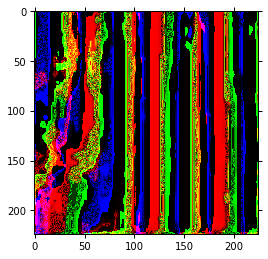

In [414]:
plt.imshow(img*256)
plt.show()

In [416]:
generative_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_95 (InputLayer)            (None, 150528)        0                                            
____________________________________________________________________________________________________
dense_95 (Dense)                 (None, 500)           75264500    input_95[0][0]                   
____________________________________________________________________________________________________
dense_96 (Dense)                 (None, 784)           392784      dense_95[0][0]                   
____________________________________________________________________________________________________
batchnormalization_48 (BatchNorm (None, 784)           3136        dense_96[0][0]                   
___________________________________________________________________________________________